In [57]:
import math
import warnings
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from pandas_datareader import DataReader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from tensorflow.keras.layers import Dense,LSTM,Dropout,GRU,SimpleRNN,Bidirectional,Embedding,SpatialDropout1D
from sklearn import metrics

warnings.filterwarnings('ignore')

In [58]:
df = DataReader("000001.SS", "yahoo", datetime.datetime(2011,1,1), datetime.datetime(2021,3,31))
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-04,2855.395996,2810.107910,2825.329102,2852.647949,110000.0,2852.647949
2011-01-05,2850.492920,2824.295898,2833.115967,2839.220947,104400.0,2839.220947
2011-01-06,2853.875000,2816.950928,2838.435059,2824.197021,84800.0,2824.197021
2011-01-07,2868.004883,2807.870117,2820.665039,2838.801025,113200.0,2838.801025
2011-01-10,2847.357910,2786.861084,2832.622070,2791.809082,90800.0,2791.809082
...,...,...,...,...,...,...
2021-03-25,3382.229980,3344.969971,3355.070068,3363.590088,270700.0,3363.590088
2021-03-26,3423.222900,3373.316895,3373.316895,3418.326904,274600.0,3418.326904
2021-03-29,3449.833984,3409.886963,3429.632080,3435.300049,284800.0,3435.300049


In [59]:
data = df.filter(['Close'])
dataset = data.values
train_data_len = math.ceil(len(dataset)*.8)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:train_data_len,:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:train_data_len,:]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

test_data = scaled_data[train_data_len-60:,:]

x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])
    y_test.append(test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))

In [60]:
model = tf.keras.Sequential([
   
    #LSTM(50, return_sequences=True,input_shape=(x_train.shape[1],1),activation='relu'),
    #Dropout(0.2),
    Bidirectional(GRU(100,return_sequences=False,activation='tanh')),
    Dropout(0.2),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test))
model.summary()

Epoch 1/20
61/61 [==============================] - 3s 50ms/step - loss: 0.0083 - val_loss: 6.3018e-04
Epoch 2/20
61/61 [==============================] - 3s 49ms/step - loss: 0.0015 - val_loss: 3.4559e-04
Epoch 3/20
61/61 [==============================] - 3s 49ms/step - loss: 9.5082e-04 - val_loss: 2.8101e-04
Epoch 4/20
61/61 [==============================] - 3s 49ms/step - loss: 8.7850e-04 - val_loss: 4.1608e-04
Epoch 5/20
61/61 [==============================] - 3s 46ms/step - loss: 6.7184e-04 - val_loss: 3.4112e-04
Epoch 6/20
61/61 [==============================] - 3s 47ms/step - loss: 6.7303e-04 - val_loss: 2.5495e-04
Epoch 7/20
61/61 [==============================] - 3s 49ms/step - loss: 6.2030e-04 - val_loss: 2.3188e-04
Epoch 8/20
61/61 [==============================] - 3s 47ms/step - loss: 6.1785e-04 - val_loss: 2.5198e-04
Epoch 9/20
61/61 [==============================] - 3s 45ms/step - loss: 5.6253e-04 - val_loss: 4.7056e-04
Epoch 10/20
61/61 [==========================

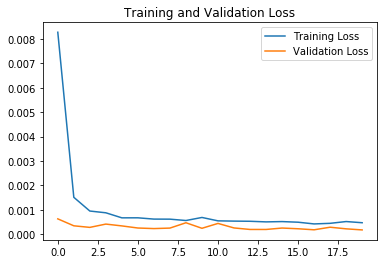

In [61]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

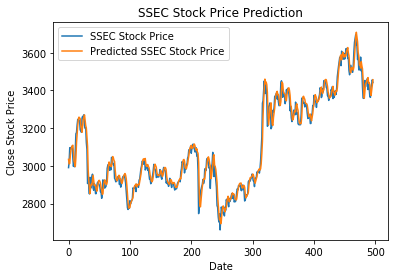

In [62]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
real_stock_price = scaler.inverse_transform(test_data[60:])

plt.plot(real_stock_price, label='SSEC Stock Price')
plt.plot(predictions,label='Predicted SSEC Stock Price')

plt.title('SSEC Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Stock Price')
plt.legend()
plt.show()

In [63]:
train = data[:train_data_len]
test = data[train_data_len:]
test['Predictions'] = predictions

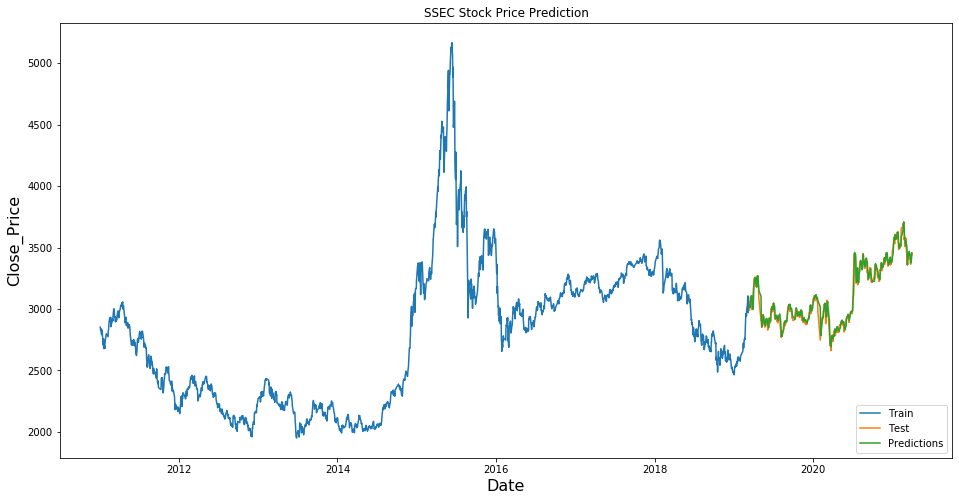

In [64]:
plt.figure(figsize=(16,8))
plt.xlabel('Date',fontsize=16)
plt.ylabel('Close_Price',fontsize=16)
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])
plt.legend(['Train','Test','Predictions'],loc = 'lower right')
plt.title('SSEC Stock Price Prediction')
plt.show()

In [65]:
mse = mean_squared_error(predictions,real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predictions,real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(real_stock_price,predictions)
print('mse: %.6f' % mse)
print('rmse: %.6f' % rmse)
print('mae: %.6f' % mae)

mse: 1832.170493
rmse: 42.803861
mae: 30.859480


In [66]:
print("R^2", r2_score(predictions,real_stock_price))

R^2 0.9688369198201133


In [67]:
mape = np.mean(np.abs((predictions - real_stock_price) / real_stock_price))*100

mape

0.9935610430426964

In [68]:
print ('%.4f%%' % (mape))

0.9936%
